# Predictive Modeling for Drunk Driving Incidents

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import plotly.graph_objects as go
import plotly.express as px
import json

# Linear Models

Starting with the census-tracts-dataset.csv. The target variables is percentage of drunk driving accidents. Be sure to set aside a validation set.



## 1. Train a linear model that takes all of the columns in the dataset and tries to predict the percentage of drunk driving accidents. [Note, you don't want to use the ID column in this analysis]. Make a histogram of the drunk driving percentage in the dataset. Compare this histogram to the predictions made by your linear model.

In [2]:
data = pd.read_csv("raw-census-tracts-dataset_clean.csv")
data = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

# Split the dataset into features (X) and target (y)
X = data.drop(columns=["DRUNK_DRIVING_PERCENTAGE"])
y = data["DRUNK_DRIVING_PERCENTAGE"]

scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.3, random_state=42)

# linear model
model_lm = LinearRegression()
model_lm.fit(X_train, y_train)

# predict the X_test
y_pred = model_lm.predict(X_test)
y_pred_train = model_lm.predict(X_train)

# MSE for model performance
mse = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)

print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Squared Error for the train set: {mse_train:.6f}")

Mean Squared Error: 51.972846
Mean Squared Error for the train set: 52.306692


In [3]:
print(data.columns)
print(data.shape)

Index(['POPULATION', 'POPULATION_DENSITY', 'RURAL_POPULATION_PERCENTAGE',
       'RURAL_POPULATION_DENSITY', 'MALE_FEMALE_RATIO', 'WHITE_ALONE',
       'BLACK_ALONE', 'AMERICAN_INDIAN_ALASKA_NATIVE_ALONE', 'ASIAN_ALONE',
       'NATIVE_HAWAIIAN_PACIFIC_ISLANDER_ALONE', 'TWO_OR_MORE_RACES',
       'HISPANIC_OR_LATINO', 'WHITE_ALONE_NOTHISPANIC_OR_LATINO',
       'MEDIAN_INCOME', 'POVERTY_RATE', 'DEMOCRAT_PERCENTAGE',
       'REPUBLICAN_PERCENTAGE', 'OBESITY_RATE', 'SMOKING_RATE',
       'DRUG_OVERDOSE_DEATH_RATE', 'PRECIPITATION', 'TOTAL_ACCIDENTS',
       'DRUNK_DRIVING_PERCENTAGE'],
      dtype='object')
(20000, 23)


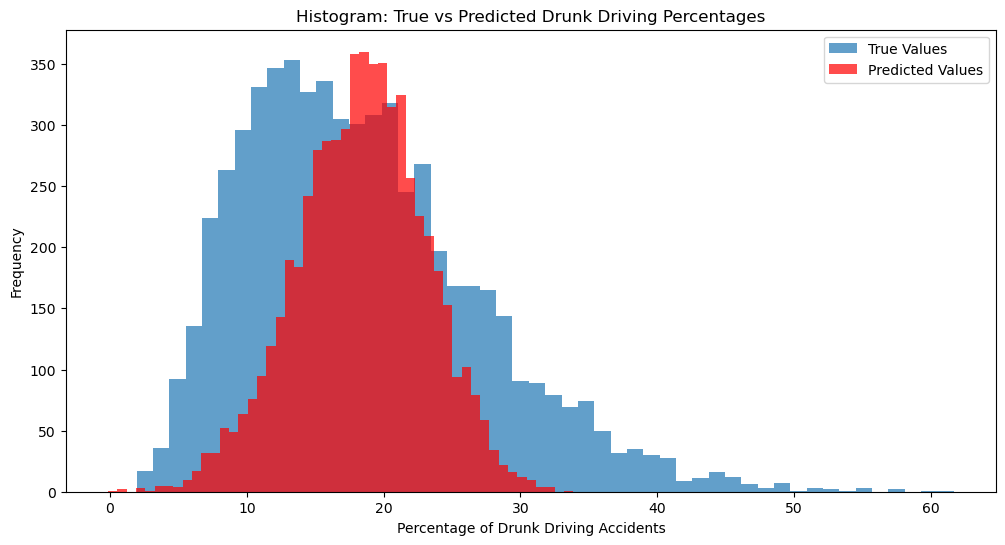

In [4]:
plt.figure(figsize=(12, 6))

plt.hist(y_test, bins=50, alpha=0.7, label='True Values')
plt.hist(y_pred, bins=50, alpha=0.7, color='red', label='Predicted Values')
plt.title("Histogram: True vs Predicted Drunk Driving Percentages")
plt.xlabel("Percentage of Drunk Driving Accidents")
plt.ylabel("Frequency")
plt.legend()

plt.show()

Comparing the two histograms, the predicted drunk driving percentage has a higher frequence around 15-20 percentage, while the true data is around 10-20. Also, there is a right skewed for the true data, while predicted data looks more normal, which means that we might lose some accuracy. But overall, the shape of predicted data is similar to the shape of the true data, which means that the predicted data is close to the test data.

## 2. Make a histogram of the linear model errors. How are they distributed?

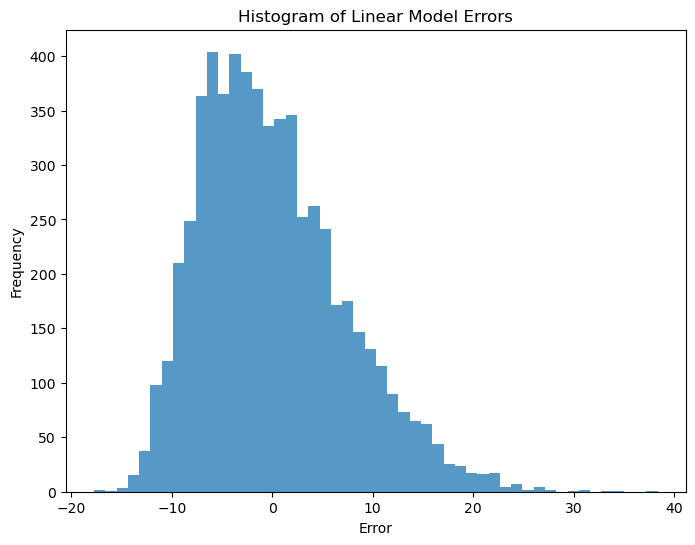

In [5]:
# errors
errors = y_test - y_pred

# histogram of errors
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=50, alpha=0.75)
plt.title("Histogram of Linear Model Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

The distribution of the error looks normal with a slightly right skewed tail. And most of errors are between (-10, 10) and the historgram of the error seems to center at 0. Therefore, this linear model is reasonably accurate, but there are still some cases where the predictions are off by more than 10 percentage points. The slightly right-skewed tail suggests that there are some cases where the model is over-predicting the values, but it is not many of them.

## 3. Tune your linear model with L1 and L2 regularization. Does this improve the MSE at all? It might not.

(Discussion of L1 and L2 could be found from pages 64-80 in lecture 6 logistic regression)
For L1 regularization, we used lasso regression. For L2 regularization, we used ridge regression. These are two common regularization methods dealing with overfitting problem by adding the penatly to the loss function. 

L1 adds a penalty equal to the absolute value of the magnitude of coefficients, while L2 adds a penalty equal to the square of the magnitude of coefficients. In general, when $w_i$ is small, L2 regression stops paying attention to it. Weights are almost never completely eliminated. With L1 regression, we care about reducing big and small weights equally. So if a feature is useless, L1 will reduce it all the way to 0. Therefore, L1 encourages feature selection and sparsity, and L2 tends to tackle multi-collinearity.

We utilized the GridSearchCV() to find the optimal hyperparameter alpha for both lasso and ridge regression, and we choosed cv=5 to have 5 fold cross-validation. The one that yields the minimal MSE would be the the optimal alpha.

In [6]:
parameters = {"alpha":10**np.linspace(-3.5, 3, 100)}

# Lasso (L1 regularization)
lasso = Lasso()
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=10)
lasso_regressor.fit(X_train, y_train)

# Ridge (L2 regularization)
ridge = Ridge()
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=10)
ridge_regressor.fit(X_train, y_train)

# Predict on the test set and compute MSE
y_pred_lasso = lasso_regressor.predict(X_test)
y_pred_ridge = ridge_regressor.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f"The MSE of predicted data for L1 Lasso with the optimal alpha {lasso_regressor.best_params_['alpha']:.5f}: {mse_lasso:.6f}")
print(f"The MSE of predicted data for L2 Ridge with the optimal alpha {ridge_regressor.best_params_['alpha']:.5f}: {mse_ridge:.6f}")
print(f"The MSE of predicted data without regularization: {mse:.6f}")


The MSE of predicted data for L1 Lasso with the optimal alpha 0.00880: 51.982462
The MSE of predicted data for L2 Ridge with the optimal alpha 56.56206: 51.975972
The MSE of predicted data without regularization: 51.972846


From this result, we did not see a substantial improvement of model performance because their MSE are really close to each other.

### Hyperparameter tuning for SGDregressor

In [7]:
loss = ['squared_error', 'huber']
penalty = ['l1', 'l2'] 
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
alpha = [0.001, 0.01, 0.1, 1] 
param_distributions = dict(loss=loss, penalty=penalty, learning_rate=learning_rate, alpha=alpha)

sgd_reg = SGDRegressor(max_iter=10000, random_state=42)
sgd_grid_search = GridSearchCV(estimator = sgd_reg, param_grid = param_distributions,
                           scoring='neg_mean_squared_error', cv = 6, n_jobs = -1)
sgd_grid_search.fit(X_train, y_train)
sgd_grid_search.best_params_

{'alpha': 0.001,
 'learning_rate': 'adaptive',
 'loss': 'squared_error',
 'penalty': 'l1'}

In [8]:
sgd_pred_test=sgd_grid_search.predict(X_test)
mse_sgd = mean_squared_error(y_test, sgd_pred_test)
print(mse_sgd)

51.97156374432909


We get the lowest mse for linear model using SGD.

# Random Forrest

## 4. Train a random forrest model on the same dataset. Report the MSE.

(From pages 94-97 in lecture 7 random forests)
Random forests are an ensemble method that is sampling with replacement, which construct many decision trees and then average the results.

The code is from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74.

    1. Random Hyperparameter Grid using RandomizedSearchCV()

In [9]:
# take a look of what parameters we can tune
rf = RandomForestRegressor(random_state=42)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


    1.1 Explain some popular or important hyperparameters

- n_estimators: how many decision trees we want to build
- max_features: max number of features considered for splitting a node in a tree.

Usually, we considered $\sqrt(p)$ where p is total number of features, while auto means the total number of features p. 


- max_depth: max number of levels in each decision tree
- min_samples_split: minimum number of samples required to split an internal node
- min_samples_leaf: minimum number of samples required to be at a leaf node
- bootstrap: a method for sampling data points (with or without replacement)

Leaf nodes represent endpoints or outcomes, while internal nodes represent decision points or hypothetical ancestors.

    1.2 Build the grid for parameters

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt'] # two methods.
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500]}


For each parameter, we would consider every combination, such as (True, 10, auto, 1, 2, 200). The total combination would be 2 * 11 * 2 * 3 * 3 * 5 = 1980. From

    1.3 Operate the random search

We set the n_iter = 100, which the number of different random combination is 100. The cv=3 means that we have 3 folds for cross validation. Increasing the number of folds may better avoid the overfitting problems.

In [11]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
# rf_random.fit(X_train, y_train)

In [12]:
# rf_random.best_params_
# {'n_estimators': 500,
# 'min_samples_split': 5,
# 'min_samples_leaf': 4,
# 'max_features': 'sqrt',
# 'max_depth': None,
# 'bootstrap': True}

    2. GridSerachCV()
Random search was to narrow down the range for each hyperparameter. We could adopt GridSerachCV() to loop throught every combination for this narrow range. 1 * 4 * 3 * 3 * 3 * 4 = 432 combinations.

In [13]:
# Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#    'max_depth': [None, 3, 4, 5],
#    'max_features': [3, 4, 5],
#    'min_samples_leaf': [3, 4, 5],
#    'min_samples_split': [3, 5, 7],
#    'n_estimators': [50, 100, 150, 200, 500, 600]}

# Create a based model
    
# rf = RandomForestRegressor()
# Instantiate the grid search model
    
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                        cv = 3, n_jobs = -1)


In [14]:
# Fit the grid search to the data
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# {'bootstrap': True,
# 'max_depth': None,
# 'max_features': 5,
# 'min_samples_leaf': 3,
# 'min_samples_split': 3,
# 'n_estimators': 500}

The default for `bootstrap` is True and the default for `max_depth` is none.

In [15]:
rf_best = RandomForestRegressor(n_estimators=500, min_samples_leaf=3,
                                min_samples_split=3, max_features=5, random_state=42)
rf_begin = RandomForestRegressor(n_estimators=100, random_state=42)

rf_best.fit(X_train, y_train)
rf_begin.fit(X_train, y_train)

rf_y_pred_train = rf_best.predict(X_train)
rf_y_pred_test = rf_best.predict(X_test)

rf_bg_pred_train = rf_begin.predict(X_train)
rf_bg_pred_test = rf_begin.predict(X_test)

rf_mse_train = mean_squared_error(y_train, rf_y_pred_train)
rf_mse_test = mean_squared_error(y_test, rf_y_pred_test)

rf_bg_mse_train = mean_squared_error(y_train, rf_bg_pred_train)
rf_bg_mse_test = mean_squared_error(y_test, rf_bg_pred_test)

print(f"The MSE of predicted train data for the best random forest model is: {rf_mse_train:.6f}")
print(f"The MSE of predicted test data for the best random forest model is: {rf_mse_test:.6f}")

print(f"The MSE of predicted train data for the original random forest model is: {rf_bg_mse_train:.6f}")
print(f"The MSE of predicted test data for the original random forest model is: {rf_bg_mse_test:.6f}")


The MSE of predicted train data for the best random forest model is: 14.495287
The MSE of predicted test data for the best random forest model is: 48.172552
The MSE of predicted train data for the original random forest model is: 6.918305
The MSE of predicted test data for the original random forest model is: 48.366435


In [16]:
rf_begin.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

By comparing with the train and test mse for both random forest models with and without the optimal hyperparameters, the mse of test data for the random forest model with the optimal hyperparameters is lower. We reached an improvement by setting the optimal parameters. The train mse with optimal hyperparameters is higher than that without optimal hyperparameters. This may indicate an overfitting problem that the original model did a good job on train set but performed less on test set.


## 6. Make a histogram of the forrest outputs vs the true data distribution. How do they compare? You can also consider making overlapping density plots instead of histograms, if you prefer.

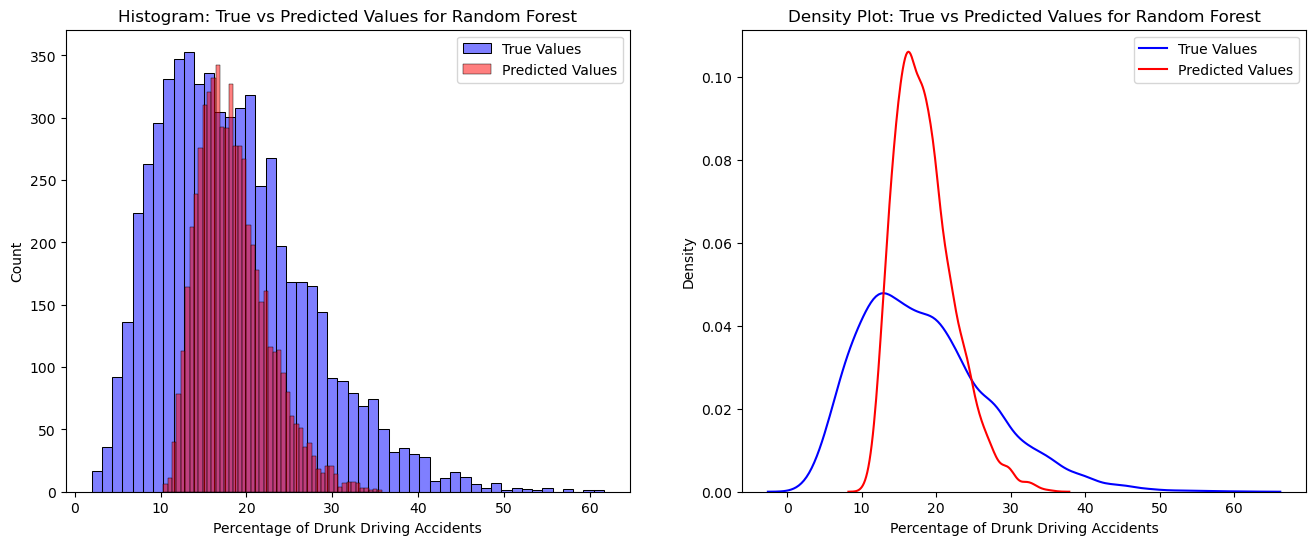

In [17]:

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(y_test, alpha=0.5, bins=50, color='blue', label='True Values', ax=axs[0])
sns.histplot(rf_y_pred_test, alpha=0.5, bins=50, color='red', label='Predicted Values', ax=axs[0])
axs[0].set_xlabel('Percentage of Drunk Driving Accidents')
axs[0].set_ylabel('Count')
axs[0].set_title('Histogram: True vs Predicted Values for Random Forest')
axs[0].legend()

# density subplot
sns.kdeplot(y_test, label='True Values', color='blue', ax=axs[1])
sns.kdeplot(rf_y_pred_test, label='Predicted Values', color='red', ax=axs[1])
axs[1].set_xlabel('Percentage of Drunk Driving Accidents')
axs[1].set_ylabel('Density')
axs[1].set_title('Density Plot: True vs Predicted Values for Random Forest')
axs[1].legend()

# Display the plot
plt.show()


By comparing the histograms and density plots of forest outputs and the true data, the true data has a wider range than the predicted values. And the predicted values has a higher density around 15-20 percentage of Drunk driving accidents.

## 7. Tune your random forrest. Can you improve it? Are any parameters important?

In [18]:
importances = rf_best.feature_importances_
feature_names = X.columns

# Print the feature ranking
print("Feature importance ranking:")

for feature in sorted(zip(importances, feature_names), reverse=True):
    print(f"{feature[1]}: {feature[0]}")


Feature importance ranking:
MEDIAN_INCOME: 0.13614990025338408
BLACK_ALONE: 0.09714139228375257
TOTAL_ACCIDENTS: 0.0935430920027524
WHITE_ALONE: 0.0561499237548841
DRUG_OVERDOSE_DEATH_RATE: 0.05019900685507492
HISPANIC_OR_LATINO: 0.042955013995182395
PRECIPITATION: 0.04178244937068403
RURAL_POPULATION_PERCENTAGE: 0.03816135207682826
DEMOCRAT_PERCENTAGE: 0.03687134463550753
POPULATION: 0.03619694893433856
WHITE_ALONE_NOTHISPANIC_OR_LATINO: 0.03607303781936853
ASIAN_ALONE: 0.03569155290538552
RURAL_POPULATION_DENSITY: 0.03399695485686863
POPULATION_DENSITY: 0.03361765670844571
SMOKING_RATE: 0.03237749563261172
OBESITY_RATE: 0.03235599658539658
REPUBLICAN_PERCENTAGE: 0.03148027418274993
POVERTY_RATE: 0.030776726428620595
MALE_FEMALE_RATIO: 0.02858428214424442
TWO_OR_MORE_RACES: 0.02774395974590756
AMERICAN_INDIAN_ALASKA_NATIVE_ALONE: 0.02701479894967494
NATIVE_HAWAIIAN_PACIFIC_ISLANDER_ALONE: 0.02113683987833708


With these feature importance, we can reduce the complexity and overfitting issues casued by the high dimensionality dataset. 

# Neural Networks

## 8. Using PyTorch, train a 3 layer neural network with Sigmoid activations on this dataset. Report the MSE. You might find this resource helpful.

We used PyTorch to train a 3 layer neural network with Sigmoid activations for our dataset.

- `torch` imports the PyTorch library.
- `nn` module contains various neural network layers and functions
- `TensorDataset` and `DataLoader` create datasets and data loaders for training and testing the model


1. Converts the training and testing data into a PyTorch tensor using the torch.tensor() function. The values attribute is used to get the array of values becuase dataframe is not allowed in tensor, and dtype=torch.float64 is used to specify that the tensor should have a floating-point data type.

In [19]:
# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)


2. Create a TensorDataset from the tensors and then a DataLoader for easy batch processing
- The `TensorDataset` combines the input data `X_train_tensor` and output data `y_train_tensor` into a single dataset that can be iterated over during training.
- The `DataLoader` allows for efficient loading and processing of the data in batches during training. The `batch_size` specifies the number of samples in each batch, and `shuffle=True` specifies that the data should be shuffled at the beginning of each epoch to prevent overfitting and improve the training process.

In [20]:
# Create a TensorDataset from the tensors and then a DataLoader for easy batch processing
torch.manual_seed(123)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

3. Define the model and loss function
- The `Sequential()` from `nn` allows for a sequence of layers to be defined in order, with each layer passing its output to the next layer in the sequence. 3 layers with the order in this case are input layer (22 * 64), hidden layer (64 * 64) and the output layer (64 * 1)
- `nn.MSELoss()` defines the loss function to be MSE
- `torch.optim.Adam()` defines the optimizer to be "Adam optimizer". The optimizer is to update the weights of the neural network during training in order to minimize the loss function MSE. Adam (Adaptive Moment Estimation) is a popular optimization algorithm for training deep neural networks, which builds upon the concepts of Stochastic Gradient Descent (SGD) that computes adaptive learning rates for each parameter, and RMSProp. 
- `model.parameters()` gets the parameters such as the weights $w_j$ and biases $b_j$ of the neural network model, which are then passed to the optimizer for updating. 

In [21]:

# Define the architecture of the model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64), # input layer, 1st layer
    nn.Sigmoid(), # Sigmoid activation function
    nn.Linear(64, 64), # hidden layer, 2nd layer
    nn.Sigmoid(), # activation function
    nn.Linear(64, 1) # output layer, 3rt layer
)

# Define the loss function and the optimizer
criterion = nn.MSELoss() # MSE
optimizer = torch.optim.Adam(model.parameters()) # Adam optimizer

4. Train the model
-  `num_epochs=5` sets the 5 number of times the entire dataset will be passed forward and backward through the neural network
- `outputs = model(inputs)` processes the input data for all layers and produces an output. (Forward pass)
- `loss = criterion(outputs, targets)` computes MSE for each epoch
- `optimizer.zero_grad()` clean the previous existing gradients of parameters before calculating the gradients of the parameters with respect to the MSE.
- `loss.backward()` is a backward pass that calculates the gradient of the loss with respect to the output and then used chain rule to the gradient of the loss with respect to each parameter. The derivative of the loss function MSE is calculated with respect to each parameter in the model. These derivatives are stored in the `.grad`.
- `optimizer.step()` updates the model's parameters after backward pass. The optimizer uses an Adam optimization to adjust each parameter slightly in the direction that reduces the loss. 

In [22]:

# Train the model
num_epochs = 5

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/5, Loss: 211.36598205566406
Epoch 2/5, Loss: 110.72993469238281
Epoch 3/5, Loss: 65.8725814819336
Epoch 4/5, Loss: 57.78986358642578
Epoch 5/5, Loss: 67.84291076660156


5. Evaluate the model using MSE
- `model.eval()` sets the model to evaluation mode
- `torch.no_grad()` constructs no computational graph
- `model(X_test_tensor)` fits the test data to the model and makes predictions. No computational graph is constructed here, and no gradients will be backpropagated based on model.eval() and torch.no_grad()
- `mse_nn.item()` extracts the single numerical value of the MSE

In [23]:

model.eval() # set the model to evaluation mode
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor).squeeze()

    
with torch.no_grad():
    y_pred_tensor_train = model(X_train_tensor).squeeze()

# Compute the mean squared error
mse_nn_train = criterion(y_pred_tensor_train, y_train_tensor)
mse_nn = criterion(y_pred_tensor, y_test_tensor)
print('Mean Squared Error of the test data in the Neural Network: ', mse_nn.item())
print('Mean Squared Error of the train data in the Neural Network: ', mse_nn_train.item())

Mean Squared Error of the test data in the Neural Network:  62.66707229614258
Mean Squared Error of the train data in the Neural Network:  62.013370513916016


## 9. Look at the distribution of outputs of your neural network. Compare it to the true distribution. Neural networks are well known to converge to the mean output. Is this happening to you? If it does happen, try to retrain your net from scratch. Is it a consistent problem?

Epoch 1/5, Loss: 211.36598205566406
Epoch 2/5, Loss: 110.72993469238281
Epoch 3/5, Loss: 65.8725814819336
Epoch 4/5, Loss: 57.78986358642578
Epoch 5/5, Loss: 67.84291076660156
Mean Squared Error of the test data in the Neural Network:  62.66707229614258
Mean Squared Error of the train data in the Neural Network:  62.013370513916016


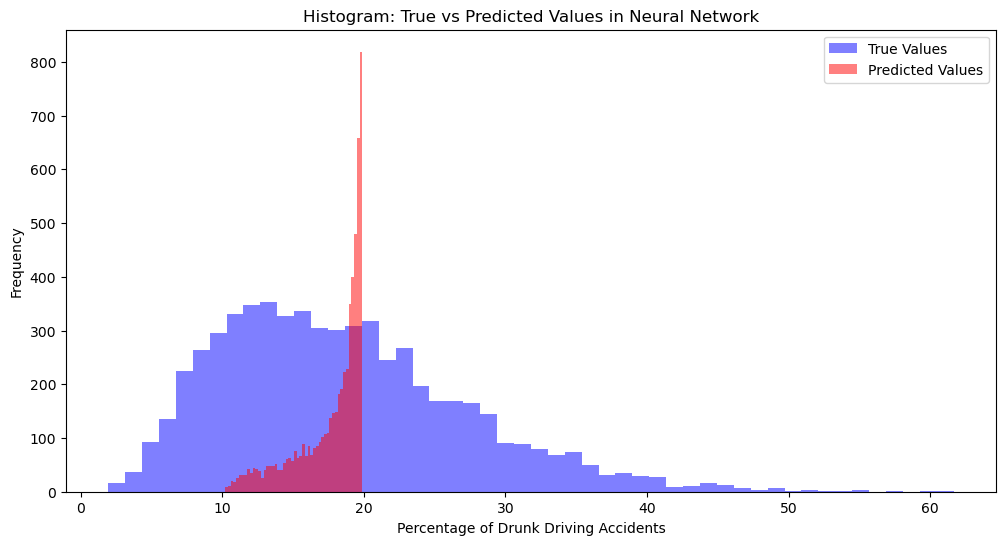

In [24]:
# Create a TensorDataset from the tensors and then a DataLoader for easy batch processing
torch.manual_seed(123)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
# Define the architecture of the model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64), # input layer, 1st layer
    nn.Sigmoid(), # Sigmoid activation function
    nn.Linear(64, 64), # hidden layer, 2nd layer
    nn.Sigmoid(), # activation function
    nn.Linear(64, 1) # output layer, 3rt layer
)

# Define the loss function and the optimizer
criterion = nn.MSELoss() # MSE
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer
# Train the model
num_epochs = 5

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
model.eval() # set the model to evaluation mode
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor).squeeze()

    
with torch.no_grad():
    y_pred_tensor_train = model(X_train_tensor).squeeze()

# Compute the mean squared error
mse_nn_train = criterion(y_pred_tensor_train, y_train_tensor)
mse_nn = criterion(y_pred_tensor, y_test_tensor)
print('Mean Squared Error of the test data in the Neural Network: ', mse_nn.item())
print('Mean Squared Error of the train data in the Neural Network: ', mse_nn_train.item())
# Convert the tensor predictions into a numpy array
y_pred_nn = y_pred_tensor.numpy()

# Plotting the histogram of true and predicted values
plt.figure(figsize=(12,6))
plt.hist(y_test, bins=50, alpha=0.5, label='True Values', color='blue')
plt.hist(y_pred_nn, bins=50, alpha=0.5, label='Predicted Values', color='red')
plt.xlabel('Percentage of Drunk Driving Accidents')
plt.ylabel('Frequency')
plt.title('Histogram: True vs Predicted Values in Neural Network')
plt.legend()
plt.show()


From the histograms plot, neural networks converged to the mean output, that is around 18 percentage of drunk driving accidents.
We want to build a complex network. We started to

- Add more neurons for each layer such as 128 for the hidden layer
    
- Using ReLU() activation functions that are less prone to the vanishing gradient problem and might help the model learn better.
    
- Adjusting a smaller learning rate 0.001 to take smaller steps when updating the weights during training, which prevents the model converge too quickly to get stuck in a suboptimal solution. Taking a smaller step would take more time to converge but it is better for an optimal solution.

This learning rate specifies the starting point and then is adaptively adjusted by the Adam optimizer during training based on the gradients.


- Increase training epochs from 5 to 10

Epoch 1/30, Loss: 64.65084838867188
Epoch 2/30, Loss: 52.98711395263672
Epoch 3/30, Loss: 54.969757080078125
Epoch 4/30, Loss: 44.91796875
Epoch 5/30, Loss: 46.109134674072266
Epoch 6/30, Loss: 49.944515228271484
Epoch 7/30, Loss: 55.49825668334961
Epoch 8/30, Loss: 29.969406127929688
Epoch 9/30, Loss: 56.006919860839844
Epoch 10/30, Loss: 41.2017936706543
Epoch 11/30, Loss: 45.33562469482422
Epoch 12/30, Loss: 50.40185546875
Epoch 13/30, Loss: 29.837324142456055
Epoch 14/30, Loss: 29.959548950195312
Epoch 15/30, Loss: 42.56398010253906
Epoch 16/30, Loss: 48.12400817871094
Epoch 17/30, Loss: 54.131568908691406
Epoch 18/30, Loss: 32.29305648803711
Epoch 19/30, Loss: 48.654502868652344
Epoch 20/30, Loss: 50.33126449584961
Epoch 21/30, Loss: 47.591400146484375
Epoch 22/30, Loss: 34.16371154785156
Epoch 23/30, Loss: 44.233421325683594
Epoch 24/30, Loss: 48.0623664855957
Epoch 25/30, Loss: 37.393211364746094
Epoch 26/30, Loss: 25.83466339111328
Epoch 27/30, Loss: 37.76414489746094
Epoch 28/

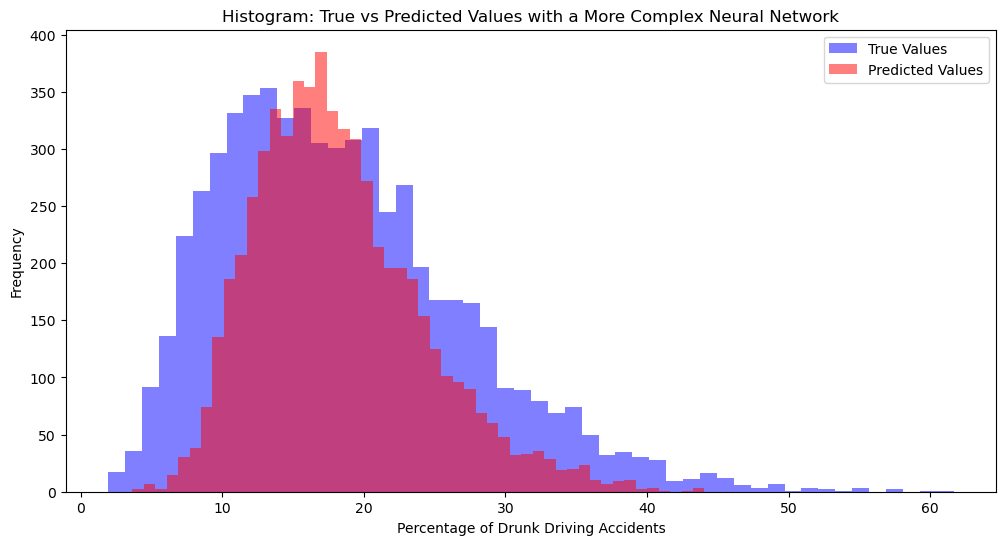

In [25]:
# Create a TensorDataset from the tensors and then a DataLoader for easy batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

model_3l_best = nn.Sequential(
    nn.Linear(X_train.shape[1], 128), 
    nn.ReLU(), 
    nn.Linear(128, 128), 
    nn.ReLU(),
    nn.Linear(128, 1) 
)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_3l_best.parameters(), lr=0.001) # smaller learning rate

# Train the model for more epochs
num_epochs = 30

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model_3l_best(inputs).squeeze()
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


model_3l_best.eval()
with torch.no_grad():
    y_pred_tensor = model_3l_best(X_test_tensor).squeeze()


mse_nn_2 = criterion(y_pred_tensor, y_test_tensor)
print('Mean Squared Error of the test data in a more complex Neural Network: ', mse_nn_2.item())

with torch.no_grad():
    y_pred_tensor_train = model_3l_best(X_train_tensor).squeeze()


mse_nn_train_2 = criterion(y_pred_tensor_train, y_train_tensor)
print('Mean Squared Error of the train data in a more complex Neural Network: ', mse_nn_train_2.item())

# Plot the new histogram
y_pred_nn_2 = y_pred_tensor.numpy()
plt.figure(figsize=(12,6))
plt.hist(y_test, bins=50, alpha=0.5, label='True Values', color='blue')
plt.hist(y_pred_nn_2, bins=50, alpha=0.5, label='Predicted Values', color='red')
plt.xlabel('Percentage of Drunk Driving Accidents')
plt.ylabel('Frequency')
plt.title('Histogram: True vs Predicted Values with a More Complex Neural Network')
plt.legend()
plt.show()

As a result, we solved the previous convergence issue and the plot has more interpretability that is similar with random forest and linear regression. What's more, the performance of this complex nueral network model is better than our orginal net model with a lower MSE.

## 10. Tune your net by adjusting the optimizer, the number of layers in the net, and the activation functions you use. If you want, you can also try adding dropout and regularization, although this might not help much. Are you able to make any improvements?

Answered in question 9

# Transfer Learning

We now turn our attention to raw_state_data_drunk_driving.csv.

## 11. Train a linear model, a neural net, and a random forrest on the data from raw_state_data_drunk_driving.csv. How do the results compare to the results you achieved on the larger dataset?

1. Data processing

In [26]:
df_state = pd.read_csv('raw_state_data_drunk_driving.csv') # shape is (50, 25)
df_state.head()

,STATE,STATE_NAME,POPULATION,POPULATION_DENSITY,RURAL_POPULATION_PERCENTAGE,RURAL_POPULATION_DENSITY,MALE_FEMALE_RATIO,WHITE_ALONE,BLACK_ALONE,AMERICAN_INDIAN_ALASKA_NATIVE_ALONE,...,MEDIAN_INCOME,POVERTY_RATE,DEMOCRAT_PERCENTAGE,REPUBLICAN_PERCENTAGE,OBESITY_RATE,SMOKING_RATE,DRUG_OVERDOSE_DEATH_RATE,PRECIPITATION,TOTAL_ACCIDENTS,DRUNK_DRIVING_PERCENTAGE_2
0,1,Alabama,5.07,99.52,41.0,40.4,93.6,69.1,26.8,0.7,...,48608.0,14.5,35.0,52.0,39.9,15.0,22.3,56.00,852,22.231
1,2,Alaska,0.73,1.28,34.0,0.4,109.2,65.3,3.7,15.6,...,67138.0,11.7,33.0,51.0,33.5,15.0,22.0,29.03,53,28.480
2,4,Arizona,7.36,64.05,10.2,5.8,98.8,82.6,5.2,5.3,...,54301.0,11.2,41.0,41.0,31.3,12.0,35.8,11.80,967,18.330
3,5,Arkansas,3.01,58.16,43.8,25.1,96.4,79.0,15.7,1.0,...,51148.0,15.1,35.0,48.0,38.7,18.0,19.1,49.72,585,26.710
4,6,California,39.03,251.90,5.1,12.7,98.9,71.9,6.5,1.6,...,76386.0,11.0,51.0,31.0,27.6,9.0,21.8,22.97,3558,25.424


2. Linear model

In [27]:
# train test split
X_state = df_state.drop(columns=['DRUNK_DRIVING_PERCENTAGE_2', 'STATE', 'STATE_NAME'])
y_state = df_state['DRUNK_DRIVING_PERCENTAGE_2']

scaler = StandardScaler()
X_state_scale = scaler.fit_transform(X_state)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_state_scale, y_state, test_size=0.2, random_state=42)


# linear model
model_lm2 = LinearRegression()
model_lm2.fit(X_train2, y_train2)

# predict the X_test
y_pred_lm2 = model_lm2.predict(X_test2)
y_pred_lm2_train = model_lm2.predict(X_train2)

# MSE for model performance
mse_lm2 = mean_squared_error(y_test2, y_pred_lm2)
mse_train_lm2 = mean_squared_error(y_train2, y_pred_lm2_train)

print(f"Mean Squared Error for test set: {mse_lm2:.6f}")
print(f"Mean Squared Error for the train set: {mse_train_lm2:.6f}")


Mean Squared Error for test set: 97.137759
Mean Squared Error for the train set: 9.433096


3. Random Forest

In [28]:
rf_2 = RandomForestRegressor(random_state=42)

rf_2.fit(X_train2, y_train2)

rf_2_pred_train = rf_2.predict(X_train2)
rf_2_pred_test = rf_2.predict(X_test2)

rf_2_mse_train = mean_squared_error(y_train2, rf_2_pred_train)
rf_2_mse_test = mean_squared_error(y_test2, rf_2_pred_test)


print(f"The MSE of predicted train data for the original random forest model is: {rf_2_mse_train:.6f}")
print(f"The MSE of predicted test data for the original random forest model is: {rf_2_mse_test:.6f}")


The MSE of predicted train data for the original random forest model is: 3.391463
The MSE of predicted test data for the original random forest model is: 60.188867


4. Nueral Network

In [29]:
# Convert the data into PyTorch tensors
torch.manual_seed(123)
X_train_tensor2 = torch.tensor(X_train2, dtype=torch.float)
y_train_tensor2 = torch.tensor(y_train2.values, dtype=torch.float)
X_test_tensor2 = torch.tensor(X_test2, dtype=torch.float)
y_test_tensor2 = torch.tensor(y_test2.values, dtype=torch.float)
# Create a TensorDataset from the tensors and then a DataLoader for easy batch processing
train_dataset2 = TensorDataset(X_train_tensor2, y_train_tensor2)
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)

model_nn2 = nn.Sequential(
    nn.Linear(X_train2.shape[1], 64), 
    nn.ReLU(), 
    nn.Linear(64, 64), 
    nn.ReLU(),
    nn.Linear(64, 1) 
)


criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model_nn2.parameters(), lr=0.01) # smaller learning rate

# Train the model for more epochs
num_epochs = 50

for epoch in range(num_epochs):
    for inputs, targets in train_loader2:
        # Forward pass
        outputs = model_nn2(inputs).squeeze()
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch %5 == 0):
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


model.eval()
with torch.no_grad():
    y_pred_tensor2 = model_nn2(X_test_tensor2).squeeze()

mse_nn_2 = criterion(y_pred_tensor2, y_test_tensor2)

with torch.no_grad():
    y_pred_tensor_train2 = model_nn2(X_train_tensor2).squeeze()
    
mse_nn_train_2 = criterion(y_pred_tensor_train2, y_train_tensor2)

print('Mean Squared Error of test data for a more complex Neural Network: ', mse_nn_2.item())
print('Mean Squared Error of train data for a more complex Neural Network: ', mse_nn_train_2.item())

Epoch 1/50, Loss: 662.3412475585938
Epoch 6/50, Loss: 168.23028564453125
Epoch 11/50, Loss: 45.95387649536133
Epoch 16/50, Loss: 43.9393424987793
Epoch 21/50, Loss: 34.14012908935547
Epoch 26/50, Loss: 11.363746643066406
Epoch 31/50, Loss: 3.123241424560547
Epoch 36/50, Loss: 2.347649097442627
Epoch 41/50, Loss: 13.744952201843262
Epoch 46/50, Loss: 5.744429588317871
Mean Squared Error of test data for a more complex Neural Network:  106.67842864990234
Mean Squared Error of train data for a more complex Neural Network:  5.9906535148620605


We used MSE as our metrics. Random forest model performed the best with the smallest MSE for this small dataset. The smaller dataset tended to have higher test MSEs and lower train MSEs. This might imply an overfitting problem due to insufficient data for training the model.

## 12. Try your best to achieve some transfer learning. Take a linear model and train it on the data from census-tracts-dataset.csv. Then, take that trained linear model and try to make predictions on the data from raw_state_data_drunk_driving.csv. Does your trained linear model transfer?

Transfer learning often involves using a model trained on a large dataset to initialize the weights for a new model that will be fine-tuned on a smaller related dataset.

The sgd_grid_search was already trainded by SGD linear model and fitted by the larger dataset 

In [30]:
sgd_tf_pred = sgd_grid_search.predict(X_state_scale)
mse_sgd_tf = mean_squared_error(y_state, sgd_tf_pred)
print(f'Mean Squared Error of a smaller dataset for a transferred SGD: {mse_sgd_tf:.6f}')

Mean Squared Error of a smaller dataset for a transferred SGD: 149.631427


In [31]:
sgd_tf_pred_test = sgd_grid_search.predict(X_test2)
mse_sgd_tf_test = mean_squared_error(y_test2, sgd_tf_pred_test)
print(f'Mean Squared Error of a test data for a transferred SGD: {mse_sgd_tf_test:.6f}')

Mean Squared Error of a test data for a transferred SGD: 251.551168


We don't see an improvement by this transferred model due to a larger MSE

## 13. Let's try to achieve some transfer via training. First, train a neural network on census-tracts-dataset.csv. Then, once this first training is done, fine-tune the network by training on the data from raw_state_data_drunk_driving.csv. Note, you might want to only train on raw_state_data_drunk_driving.csv for a few iterations, since it is small and you risk overfitting if you train for a long time. How do your results compare to the results from 11? Does transfer help at all?



In [32]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model_3l_best = nn.Sequential(
    nn.Linear(X_train.shape[1], 128), 
    nn.ReLU(), 
    nn.Linear(128, 128), 
    nn.ReLU(),
    nn.Linear(128, 1) 
)


criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model_3l_best.parameters(), lr=0.001) # smaller learning rate

# Train the model for more epochs
num_epochs = 10

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model_3l_best(inputs).squeeze()
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


torch.manual_seed(123)
train_dataset2 = TensorDataset(X_train_tensor2, y_train_tensor2)
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)

criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model_3l_best.parameters(), lr=0.005) # smaller learning rate
num_epochs = 40
for epoch in range(num_epochs):
    for inputs, targets in train_loader2:
        # Forward pass
        outputs = model_3l_best(inputs).squeeze()
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch % 5 == 0):  
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


model_3l_best.eval()
with torch.no_grad():
    y_pred_tf_tensor = model_3l_best(X_test_tensor2).squeeze()

mse_3l_tf = criterion(y_pred_tf_tensor, y_test_tensor2)

with torch.no_grad():
    y_pred_tf_tensor_train = model_3l_best(X_train_tensor2).squeeze()
    
mse_3l_tf_train = criterion(y_pred_tf_tensor_train, y_train_tensor2)

print('Mean Squared Error of test data for a more complex Neural Network: ', mse_3l_tf.item())
print('Mean Squared Error of train data for a more complex Neural Network: ', mse_3l_tf_train.item())

Epoch 1/40, Loss: 78.07414245605469
Epoch 6/40, Loss: 31.28841209411621
Epoch 11/40, Loss: 33.47747802734375
Epoch 16/40, Loss: 7.54876184463501
Epoch 21/40, Loss: 2.367603302001953
Epoch 26/40, Loss: 3.1084237098693848
Epoch 31/40, Loss: 6.732132434844971
Epoch 36/40, Loss: 2.2062923908233643
Mean Squared Error of test data for a more complex Neural Network:  102.84676361083984
Mean Squared Error of train data for a more complex Neural Network:  1.5406644344329834


As a result, the MSE for test data was 86.651 and the MSE for train data was 1.813978, where both the train MSE and the test MSE decreased. Therefore, this transfer helped to predict the data in the neural network model.

Note that actually achieving transfer is rather difficult. You won't be penalized if you can't get this section to work fully, so long as you make an honest attempt. I had to use a 9 layer neural network to get it to work reliably.

# Visualization

## 14. Construct a Choropleth map of the US States. States should be colored by the percentage of drunk driving accidents in that state.

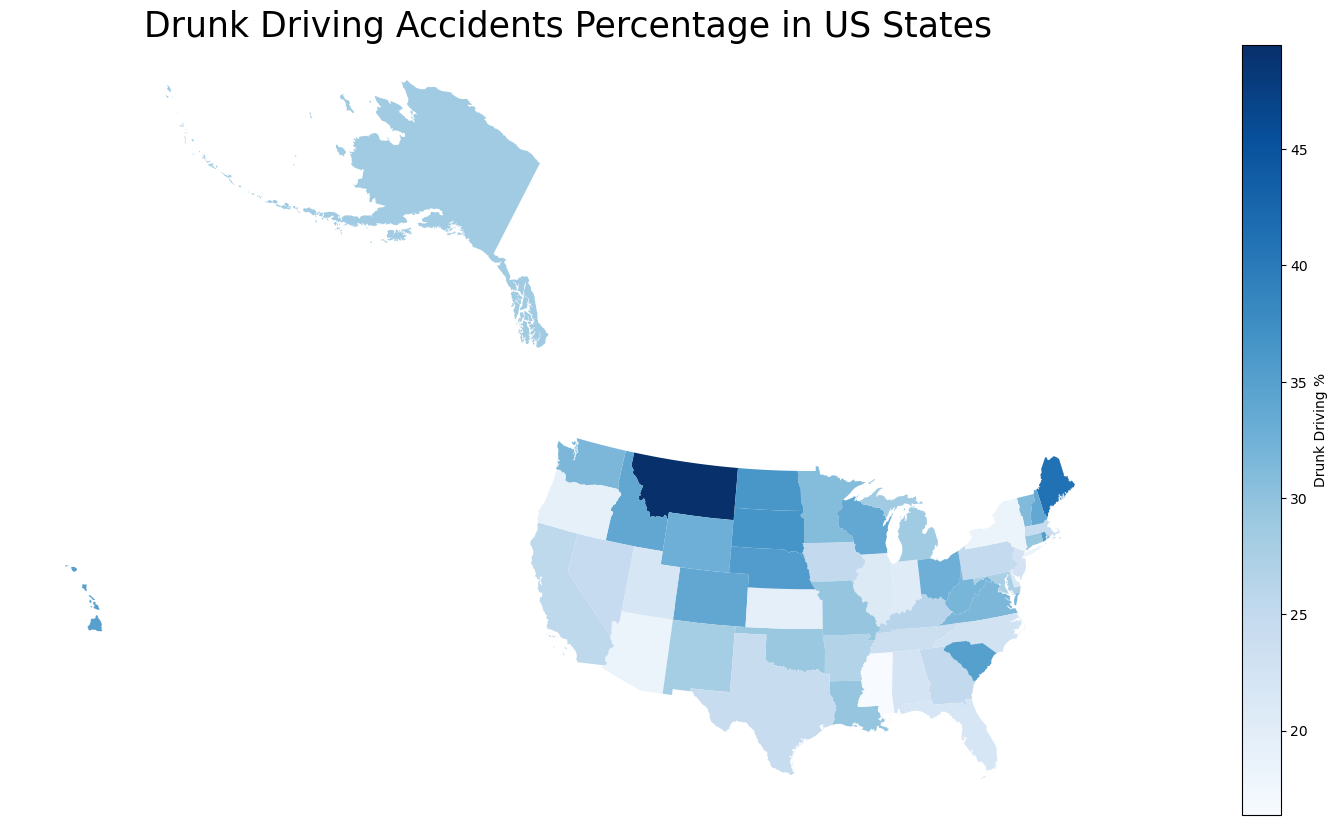

In [33]:
import geopandas as gpd

us_map = gpd.read_file('gz_2010_us_040_00_20m.json')

# Merge the US map and your data using the 'NAME' and 'STATE_NAME' column as the key
merged = pd.merge(us_map, df_state, left_on="NAME", right_on="STATE_NAME")

# Transform to a projected CRS
merged = merged.to_crs('EPSG:5070')

fig, ax = plt.subplots(1, 1, figsize=(30, 10))

merged.plot(column='DRUNK_DRIVING_PERCENTAGE_2', cmap='Blues', legend=True, ax=ax, legend_kwds={'label': "Drunk Driving %"})

plt.title('Drunk Driving Accidents Percentage in US States', fontdict={'fontsize': '25', 'fontweight' : '3'})
plt.axis('off')
plt.show()



## 15. Construct a second Choropleth map. This time, pick one of your predictive models and plot its errors on the map. Each state should be color coded by the magnitude of your estimator's error. What states are the easiest to predict? What states are the hardest?

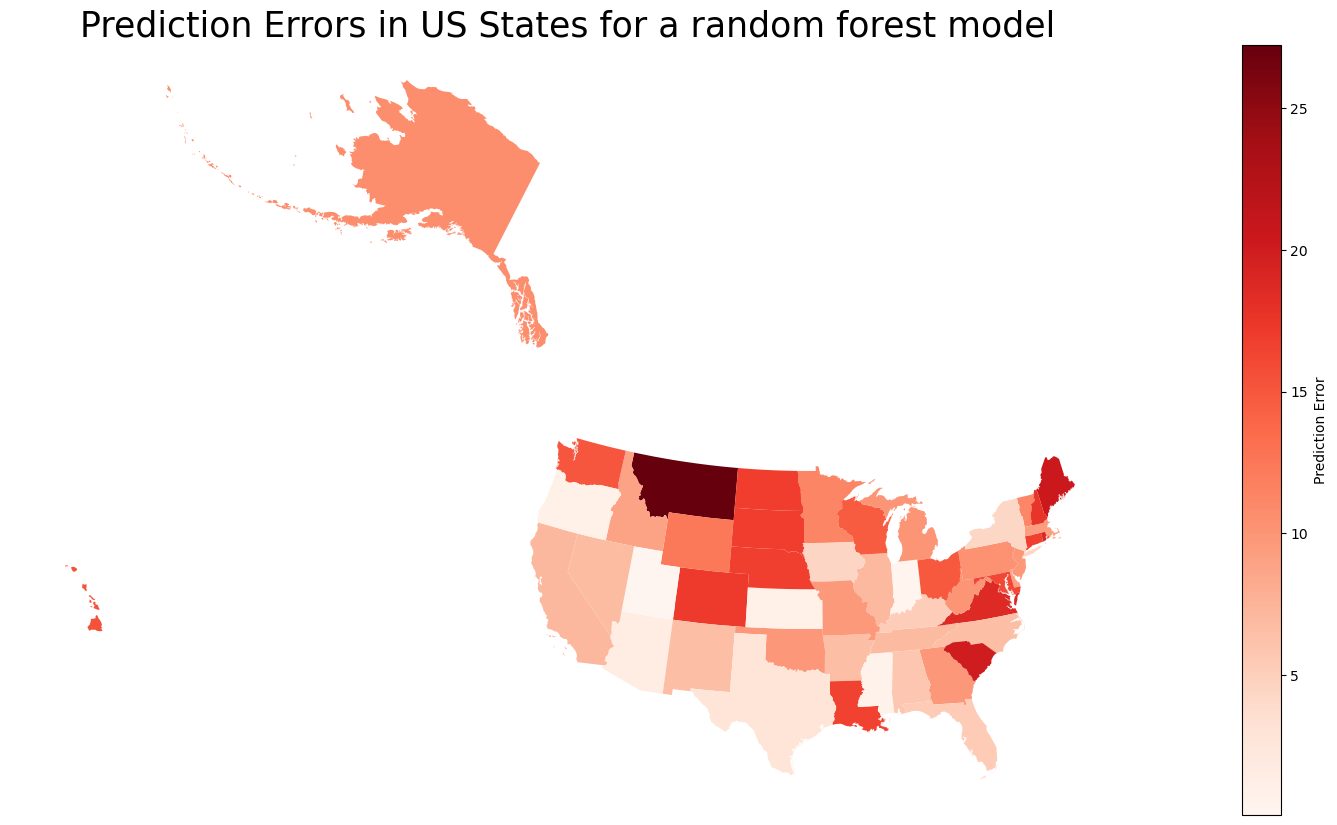

In [34]:

rf_best_pred = rf_best.predict(X_state_scale)

pred_error = abs(y_state - rf_best_pred)

df_state['rf_best_pred'] = rf_best_pred
df_state['pred_error'] = pred_error

merged = pd.merge(us_map, df_state, left_on="NAME", right_on="STATE_NAME")

# Transform to a projected CRS
merged = merged.to_crs('EPSG:5070')

fig, ax = plt.subplots(1, 1, figsize=(30, 10))

merged.plot(column='pred_error', cmap='Reds', legend=True, ax=ax, legend_kwds={'label': "Prediction Error"})

plt.title('Prediction Errors in US States for a random forest model', fontdict={'fontsize': '25', 'fontweight' : '3'})
plt.axis('off')
plt.show()

In [35]:
df_state[["STATE_NAME", "DRUNK_DRIVING_PERCENTAGE_2", "rf_best_pred", "pred_error"]].sort_values(by="pred_error", ascending=False)[:5]

,STATE_NAME,DRUNK_DRIVING_PERCENTAGE_2,rf_best_pred,pred_error
25,Montana,49.480,22.266565,27.213435
18,Maine,41.173,20.727644,20.445356
39,South Carolina,35.097,15.029256,20.067744
38,Rhode Island,35.403,16.386975,19.016025
45,Virginia,31.605,12.959052,18.645948


In [36]:
df_state[["STATE_NAME", "DRUNK_DRIVING_PERCENTAGE_2", "rf_best_pred", "pred_error"]].sort_values(by="pred_error", ascending=True)[:5]

,STATE_NAME,DRUNK_DRIVING_PERCENTAGE_2,rf_best_pred,pred_error
43,Utah,21.924,22.004186,0.080186
13,Indiana,20.442,20.130449,0.311551
23,Mississippi,16.369,15.756229,0.612771
15,Kansas,19.381,18.399081,0.981919
36,Oregon,19.326,20.326954,1.000954


## Work Sited

Will Koehrsen. "Hyperparameter Tuning the Random Forest in Python using Scikit-Learn." Towards Data Science, Jan 9th, 2018, URL: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74.